### Challenge Homepage

https://priceisyourright.org/

In [33]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

## Load data

In [4]:
ma_data = pd.read_csv('data/CHAI_MA-cost-estimates.csv')
nh_data = pd.read_csv('data/NHID_cost-estimates.csv')

/Users/Tuxedo/scratch/priceisyourrightchallenge/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/Tuxedo/scratch/priceisyourrightchallenge/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0,7,47,48,49,51,52,53,55,56,57) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
print('num rows massachussetts data:', len(ma_data))
print('num rows new hampshire data:', len(nh_data))

num rows massachussetts data: 113813
num rows new hampshire data: 67809


## Filter data down to columns of relevance

In [6]:
ma_data_slim = ma_data[['ProviderOrgName_Anchored', 'ProviderTaxonomyType', 'ProviderTaxonomyGroup',  'ZIP',
 'ServiceCode',
 'CostEstimate',
 'NumberServices',
 'ServiceType_Level1',
 'ServiceType_Level2',
 'ServiceType_Level3',
 'ServiceType_Level4',
 'ServiceDescription',
 'NumberProvs_forPayerAndService',
 'NumberServices_All',
 'TotalCost_All']].sample(frac=1)

In [7]:
nh_data_slim = nh_data[['PROCEDURE_CODE',
 'PROCEDURE_NAME',
 'SHORT_DESCRIPTION',
 'CATEGORY_NAME',
 'COVERAGE_CLASS',
 ' MED_ALLOW ',
 'PRICE_PERCISION',
 'PATIENT_COMPLEXITY',
 'PAYER',
 'PLAN_TYPE',
 'PROVIDER_NAME']].sample(frac=1)

## Basic Preprocessing

In [8]:
nh_data_slim['PROCEDURE_CODE_STR']= nh_data_slim.PROCEDURE_CODE.apply(str)

In [9]:
ma_data_slim['ServiceCode_STR'] = ma_data_slim.ServiceCode.apply(str)

### Group services into buckets

In [10]:
nh_data_slim.CATEGORY_NAME.value_counts()

Diagnostic Services                12265
Office Visits                      11074
Dental Fillings                     8418
Laboratory Services                 7410
Behavioral Health Care              7233
Preventive Care                     6219
Physical Therapy                    4963
Radiology Services                  3459
Other Dental Services               1755
Ambulance Services                  1625
Outpatient Tests and Procedures     1378
Chiropractic Care                   1377
Emergency Visits                     511
Orthodontic Services                 122
Name: CATEGORY_NAME, dtype: int64

In [11]:
nh_data_slim.head()

,PROCEDURE_CODE,PROCEDURE_NAME,SHORT_DESCRIPTION,CATEGORY_NAME,COVERAGE_CLASS,MED_ALLOW,PRICE_PERCISION,PATIENT_COMPLEXITY,PAYER,PLAN_TYPE,PROVIDER_NAME,PROCEDURE_CODE_STR
9806,85025,Blood test for complete blood cell count and a...,Complete blood cell count and white blood cell...,Laboratory Services,MED,$33,LOW,NaN,Harvard Pilgrim HC,Individual (self-purchased) Medical Plans,NEW LONDON HOSPITAL,85025
63064,D2391,"White (Resin) Dental Filling - One surface, po...","White (Resin) Dental Filling - One surface, po...",Dental Fillings,DEN,$245,MEDIUM,NaN,Delta Dental - NH,All Dental Plans,AMIDON FAMILY DENTISTRY,D2391
41357,D0140,Problem focused evaluation limited to a specif...,Problem focused evaluation limited to a specif...,Diagnostic Services,DEN,$113,MEDIUM,NaN,Metropolitan Life,All Dental Plans,"GREGORY L SHAKER, DDS",D0140
50718,D0330,"X-Ray Dental - Whole mouth, from outside mouth","X-Ray Dental - Whole mouth, from outside mouth",Diagnostic Services,DEN,$137,LOW,NaN,Delta Dental - NH,All Dental Plans,NORTHEAST ORAL SURGERY AND DENTAL IMPLANT,D0330
53484,D1120,Child Dental Cleaning,Child Dental Cleaning,Preventive Care,DEN,$172,VERY LOW,NaN,Metropolitan Life,All Dental Plans,"ALICIA JOY WILLETTE, DDS",D1120


In [12]:
ma_data_slim.ServiceType_Level1.value_counts()

Office Visits                        61905
Behavioral Health                    17815
Physical and Occupational Therapy    11109
Laboratory and Pathology Testing     10378
Radiology                             6342
Eye exams                             3499
Ambulance/Transportation Services      949
Colonoscopy and Endoscopy              706
Maternity                              684
Emergency Department Visits            426
Name: ServiceType_Level1, dtype: int64

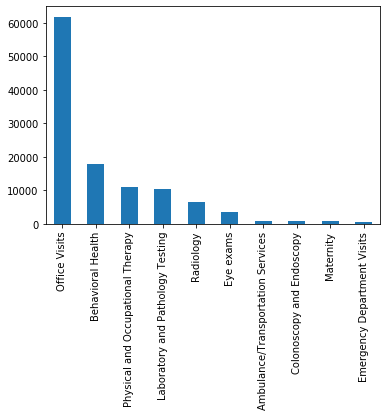

In [13]:
ma_data_slim['ServiceType_Level1'].value_counts().plot(kind='bar')

In [14]:
ma_data_slim.loc[ma_data_slim.ServiceType_Level1 == 'Emergency Department Visits']['ServiceType_Level2'].value_counts()

Moderate severity problems                         114
High severity but non-life-threatening problems     96
Low to moderate severity problems                   85
Life-threatening problems                           74
Minor problems                                      57
Name: ServiceType_Level2, dtype: int64

In [15]:
ma_data_slim.loc[ma_data_slim.ServiceType_Level1 == 'Emergency Department Visits']['ServiceType_Level3'].value_counts()

Series([], Name: ServiceType_Level3, dtype: int64)

In [16]:
ma_data_slim.loc[ma_data_slim.ServiceType_Level1 == 'Emergency Department Visits']['ServiceType_Level4'].value_counts()

Series([], Name: ServiceType_Level4, dtype: int64)

In [17]:
ma_data_slim.loc[ma_data_slim.ServiceType_Level1 == 'Office Visits']['ServiceType_Level2'].value_counts()

Presenting with a problem    45763
Preventive care              14537
Consultation                  1605
Name: ServiceType_Level2, dtype: int64

In [18]:
ma_data_slim.loc[ma_data_slim.ServiceType_Level1 == 'Office Visits']['ServiceType_Level3'].value_counts()

Established patient    47788
New patient            12512
60 minutes               751
40 minutes               611
80 minutes               132
30 minutes                99
15 minutes                12
Name: ServiceType_Level3, dtype: int64

In [19]:
ma_data_slim.loc[ma_data_slim.ServiceType_Level1 == 'Office Visits']['ServiceType_Level4'].value_counts()

15 minutes         15090
25 minutes         12994
Age 18 to 39        5107
Age 40 to 64        4807
30 minutes          4291
10 minutes          4007
45 minutes          3626
40 minutes          2381
20 minutes          1433
Age 0 to 1          1187
60 minutes          1177
Age 5 to 11         1114
Age 12 to 17        1045
Age 1 to 4           840
5 minutes            764
Age 65 or older      437
Name: ServiceType_Level4, dtype: int64

## CPT codes mapping between data sets

- <b>nh_data.PROCEDURE_CODE is equal to ma_data.ServiceCode</b>

In [20]:
nh_data_slim.loc[nh_data_slim.PROCEDURE_CODE_STR == '70450'].head()

,PROCEDURE_CODE,PROCEDURE_NAME,SHORT_DESCRIPTION,CATEGORY_NAME,COVERAGE_CLASS,MED_ALLOW,PRICE_PERCISION,PATIENT_COMPLEXITY,PAYER,PLAN_TYPE,PROVIDER_NAME,PROCEDURE_CODE_STR
1481,70450,"CT - Head/Brain, without dye","CT - Head/Brain, without dye",Radiology Services,MED,"$1,713",MEDIUM,MEDIUM,Other Medical Insurance,Group (employer) Medical Plans,ST. JOSEPH HOSPITAL,70450
1487,70450,"CT - Head/Brain, without dye","CT - Head/Brain, without dye",Radiology Services,MED,"$1,182",MEDIUM,MEDIUM,Harvard Pilgrim HC,Individual (self-purchased) Medical Plans,EXETER HOSPITAL,70450
1499,70450,"CT - Head/Brain, without dye","CT - Head/Brain, without dye",Radiology Services,MED,$735,VERY LOW,MEDIUM,Harvard Pilgrim HC,Group (employer) Medical Plans,CHESHIRE MEDICAL CENTER,70450
1488,70450,"CT - Head/Brain, without dye","CT - Head/Brain, without dye",Radiology Services,MED,"$2,030",MEDIUM,MEDIUM,Other Medical Insurance,Group (employer) Medical Plans,EXETER HOSPITAL,70450
1495,70450,"CT - Head/Brain, without dye","CT - Head/Brain, without dye",Radiology Services,MED,$597,HIGH,MEDIUM,Harvard Pilgrim HC,Group (employer) Medical Plans,SOUTHERN NH MEDICAL CENTER,70450


## We only have 150 CPTs, not enough to rebuild CPT index

In [71]:
cpt_descriptions = list(set(nh_data_slim.PROCEDURE_NAME.values))
len(cpt_descriptions)

150

In [72]:
ma_data_slim.loc[ma_data_slim.ServiceCode_STR == '70450'].head()

,ProviderOrgName_Anchored,ProviderTaxonomyType,ProviderTaxonomyGroup,ZIP,ServiceCode,CostEstimate,NumberServices,ServiceType_Level1,ServiceType_Level2,ServiceType_Level3,ServiceType_Level4,ServiceDescription,NumberProvs_forPayerAndService,NumberServices_All,TotalCost_All,ServiceCode_STR
1361,Signature Healthcare Brockton Hospital,General Acute Care Hospital,Acute Hospital,2302,70450,369.67,476,Radiology,CT Scan,Head or brain,Without contrast,"CT scan of head or brain, diagnostic, without ...",105,476,141953.04,70450
1352,"Radiology & Imaging, Inc.",Physician: Radiology,Physician,1107,70450,260.57,26,Radiology,CT Scan,Head or brain,Without contrast,"CT scan of head or brain, diagnostic, without ...",105,26,5717.37,70450
1304,Portsmouth Regional Hospital,General Acute Care Hospital,Acute Hospital,3801,70450,1568.37,27,Radiology,CT Scan,Head or brain,Without contrast,"CT scan of head or brain, diagnostic, without ...",105,27,43088.47,70450
1305,"UMASS Memorial Medical Center, Inc.",General Acute Care Hospital,Acute Hospital,1655,70450,518.63,685,Radiology,CT Scan,Head or brain,Without contrast,"CT scan of head or brain, diagnostic, without ...",105,685,340052.37,70450
1358,Hallmark Health System Inc,General Acute Care Hospital,Acute Hospital,2155,70450,485.94,684,Radiology,CT Scan,Head or brain,Without contrast,"CT scan of head or brain, diagnostic, without ...",105,684,276404.19,70450


In [73]:
nh_data_slim[['PROCEDURE_CODE', 'PROCEDURE_NAME']].head(10)

,PROCEDURE_CODE,PROCEDURE_NAME
9806,85025,Blood test for complete blood cell count and a...
63064,D2391,"White (Resin) Dental Filling - One surface, po..."
41357,D0140,Problem focused evaluation limited to a specif...
50718,D0330,"X-Ray Dental - Whole mouth, from outside mouth"
53484,D1120,Child Dental Cleaning
44559,D0210,X-Ray Dental - Complete intraoral series
37154,99396,Comp Preventive Medicine 40-64 yrs old
61136,D2331,"White (Resin) Dental Filling - Two surfaces, a..."
10759,87081,Test for disease-causing (pathogenic) organism...
48905,D0274,X-Ray Dental - Four images - bitewings


## Breakdown of services and costs rendered by Provider

In [70]:
ma_data_slim.head()

,ProviderOrgName_Anchored,ProviderTaxonomyType,ProviderTaxonomyGroup,ZIP,ServiceCode,CostEstimate,NumberServices,ServiceType_Level1,ServiceType_Level2,ServiceType_Level3,ServiceType_Level4,ServiceDescription,NumberProvs_forPayerAndService,NumberServices_All,TotalCost_All,ServiceCode_STR
53653,Medical Care of Boston Management Corporation,Physician: Family Medicine,Physician,2492,99203,171.14,31,Office Visits,Presenting with a problem,New patient,30 minutes,"New patient office or other outpatient visit, ...",4291,43,7616.96,99203
197,"Steward Holy Family Hospital, Inc.",General Acute Care Hospital,Acute Hospital,1844,43239 w/ polyp removal,2984.23,27,Colonoscopy and Endoscopy,Endoscopy,With biopsy,Performed with polyp removal,"Biopsy of the esophagus, stomach, and/or upper...",35,27,90424.23,43239 w/ polyp removal
82022,Plymouth Bay Orthopedic Associates Inc.,"Physician: Neuromusculoskeletal Medicine, Spor...",Physician,2332,99214,133.32,87,Office Visits,Presenting with a problem,Established patient,25 minutes,Established patient office or other outpatient...,12994,97,13034.63,99214
62137,Medical Care of Boston Management Corporation,Physician: Internal Medicine,Internal Medicine,2446,99212,71.50,17,Office Visits,Presenting with a problem,Established patient,10 minutes,Established patient office or other outpatient...,3832,24,1837.19,99212
79179,"Ear, Nose & Throat Surgeons of Western New Eng...",Physician: Otolaryngology,Physician,1107,99213,97.82,135,Office Visits,Presenting with a problem,Established patient,15 minutes,Established patient office or other outpatient...,15090,228,22738.38,99213


In [23]:
ma_data_slim.groupby('ProviderOrgName_Anchored')[['ServiceCode', 'CostEstimate']].agg({'ServiceCode': lambda x: list(x), 'CostEstimate': ['sum', 'mean', 'median']})

ServiceCode  \
                                                                       <lambda>   
ProviderOrgName_Anchored                                                          
1 On 1 Eyecare                                                   [92014, 92004]   
2 Thumbs Up Hand Therapy LLC  [97110, 97112, 97112, 97003, 97140, 97003, 975...   
20 20 Eye Care PC                           [99213, 92012, 92002, 92004, 92014]   
60 Quaker Highway Inc.               [97140, 97112, 97110, 97001, 97002, 97530]   
711 Pedicare                                                            [99214]   
...                                                                         ...   
Zinaida Levin MD PC                  [99214, 99396, 99395, 99211, 99212, 99213]   
Zine Counseling, LLC                                      [90847, 90834, 90847]   
Zofia S Mroczka MD                          [99204, 99213, 99214, 99215, 99205]   
Zorn Family Chiropractic                                                [97140]   
Zouhdi Hajjaj, M.D.                                [99396, 99213, 99204, 99395]   

                             CostEstimate                       
                                      sum        mean   median  
ProviderOrgName_Anchored                                        
1 On 1 Eyecare                    254.400  127.200000  127.200  
2 Thumbs Up Hand Therapy LLC      749.800   44.105882   24.380  
20 20 Eye Care PC                 846.320  169.264000  142.360  
60 Quaker Highway Inc.            201.645   33.607500   27.885  
711 Pedicare                      105.000  105.000000  105.000  
...                                   ...         ...      ...  
Zinaida Levin MD PC               773.430  128.905000  143.390  
Zine Counseling, LLC              198.770   66.256667   65.000  
Zofia S Mroczka MD                858.600  171.720000  177.980  
Zorn Family Chiropractic           37.470   37.470000   37.470  
Zouhdi Hajjaj, M.D.               607.260  151.815000  161.130  

[14245 rows x 4 columns]

In [83]:
pdf = ma_data_slim.groupby('ProviderOrgName_Anchored')[['ServiceCode', 'NumberServices', 'CostEstimate']].agg({'ServiceCode': lambda x: list(x), 'NumberServices': lambda x: list(x), 'CostEstimate': lambda x: list(x)}).reset_index()

pdf['NumberServices_TOTAL'] = pdf.NumberServices.apply(sum)
pdf['ServiceRatio'] = pdf.apply(lambda row: [round(row['NumberServices'][i] / row['NumberServices_TOTAL'], 2) for i in range(len(row['ServiceCode']))], axis=1)
pdf['CostEstimate'] = pdf.apply(lambda row: [round(row['CostEstimate'][i], 2) for i in range(len(row['CostEstimate']))], axis=1)
pdf.head()

,ProviderOrgName_Anchored,ServiceCode,NumberServices,CostEstimate,NumberServices_TOTAL,ServiceRatio
0,1 On 1 Eyecare,"[92014, 92004]","[42, 349]","[112.57, 141.83]",391,"[0.11, 0.89]"
1,2 Thumbs Up Hand Therapy LLC,"[97110, 97112, 97112, 97003, 97140, 97003, 975...","[193, 284, 22, 43, 38, 23, 66, 63, 362, 21, 18...","[22.13, 23.19, 24.38, 105.88, 20.62, 113.5, 24...",2251,"[0.09, 0.13, 0.01, 0.02, 0.02, 0.01, 0.03, 0.0..."
2,20 20 Eye Care PC,"[99213, 92012, 92002, 92004, 92014]","[91, 215, 72, 255, 728]","[116.67, 142.36, 135.84, 245.84, 205.61]",1361,"[0.07, 0.16, 0.05, 0.19, 0.53]"
3,60 Quaker Highway Inc.,"[97140, 97112, 97110, 97001, 97002, 97530]","[141, 95, 139, 16, 97, 16]","[17.18, 23.19, 32.58, 77.25, 50.0, 1.44]",504,"[0.28, 0.19, 0.28, 0.03, 0.19, 0.03]"
4,711 Pedicare,[99214],[22],[105.0],22,[1.0]


In [29]:
ma_data_slim.loc[ma_data_slim.ProviderOrgName_Anchored == '60 Quaker Highway Inc.']

,ProviderOrgName_Anchored,ProviderTaxonomyType,ProviderTaxonomyGroup,ZIP,ServiceCode,CostEstimate,NumberServices,ServiceType_Level1,ServiceType_Level2,ServiceType_Level3,ServiceType_Level4,ServiceDescription,NumberProvs_forPayerAndService,NumberServices_All,TotalCost_All,ServiceCode_STR
47865,60 Quaker Highway Inc.,Physical Therapist,Physical Therapist,1569,97140,17.185,141,Physical and Occupational Therapy,Physical therapy,Manual (physical) therapy techniques to 1 or m...,NaN,Manual for one or more regions of body - 15 mi...,2213,141,4276.91,97140
45124,60 Quaker Highway Inc.,Physical Therapist,Physical Therapist,1569,97112,23.190,95,Physical and Occupational Therapy,Physical therapy,Therapeutic procedure to re-educate brain-to-n...,NaN,Therapy for neuromuscular reeducation - 15 min...,1566,95,2371.28,97112
44555,60 Quaker Highway Inc.,Physical Therapist,Physical Therapist,1569,97110,32.580,139,Physical and Occupational Therapy,Physical therapy,"Therapeutic exercise to develop strength, endu...",NaN,Physical therapy exercises - 15 minutes,2639,139,6211.63,97110
39551,60 Quaker Highway Inc.,Physical Therapist,Physical Therapist,1569,97001,77.250,16,Physical and Occupational Therapy,Physical therapy,Evaluation,NaN,Physical therapy evaluation,1497,16,1236.00,97001
40992,60 Quaker Highway Inc.,Physical Therapist,Physical Therapist,1569,97002,50.000,97,Physical and Occupational Therapy,Physical therapy,Re-evaluation,NaN,Physical therapy re-evaluation,722,97,4850.00,97002
49362,60 Quaker Highway Inc.,Physical Therapist,Physical Therapist,1569,97530,1.440,16,Physical and Occupational Therapy,Physical therapy,"Therapeutic activities to improve function, wi...",NaN,"Physical therapy exercise, in-person with ther...",852,16,25.14,97530


## creating a pivot table with magnitudes of Service Codes.. similar to CSR Matrix so it can be used to do KNN

- https://towardsdatascience.com/how-did-we-build-book-recommender-systems-in-an-hour-part-2-k-nearest-neighbors-and-matrix-c04b3c2ef55c
- https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html
- http://www.ieee.ma/uaesb/pdf/distances-in-classification.pdf



In [ ]:
ma_sc_pivot = ma_data_slim.pivot_table(index='ProviderOrgName_Anchored', columns='ServiceCode', values='NumberServices').fillna(0)
ma_sc_matrix = csr_matrix(ma_sc_pivot.values)

In [56]:
model_knn = NearestNeighbors(metric = 'manhattan', algorithm= 'auto')
model_knn.fit(ma_sc_matrix)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='manhattan',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [57]:
query_index = np.random.choice(ma_sc_pivot.shape[0])

In [88]:
distances, indices = model_knn.kneighbors(ma_sc_pivot.iloc[query_index, :].values.reshape(1,-1), n_neighbors = 6)

In [89]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for: {}\n'.format(ma_sc_pivot.index[query_index]))
    else:
        print('{0}: {1}, with distance: {2}'.format(i, ma_sc_pivot.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for: Constance Pike LICSW

1: Christine M Senechal LICSW, with distance: 8.0
2: Harry Remer, with distance: 9.0
3: Life Guidance, with distance: 9.0
4: Susan J. Phipps M.Ed., LMHC, with distance: 10.0
5: Jill Fitzgerald LMHC, with distance: 13.0


In [64]:
pdf.head()

,ProviderOrgName_Anchored,ServiceCode,NumberServices,NumberServices_TOTAL,ServiceRatio
0,1 On 1 Eyecare,"[92014, 92004]","[42, 349]",391,"[0.11, 0.89]"
1,2 Thumbs Up Hand Therapy LLC,"[97110, 97112, 97112, 97003, 97140, 97003, 975...","[193, 284, 22, 43, 38, 23, 66, 63, 362, 21, 18...",2251,"[0.09, 0.13, 0.01, 0.02, 0.02, 0.01, 0.03, 0.0..."
2,20 20 Eye Care PC,"[99213, 92012, 92002, 92004, 92014]","[91, 215, 72, 255, 728]",1361,"[0.07, 0.16, 0.05, 0.19, 0.53]"
3,60 Quaker Highway Inc.,"[97140, 97112, 97110, 97001, 97002, 97530]","[141, 95, 139, 16, 97, 16]",504,"[0.28, 0.19, 0.28, 0.03, 0.19, 0.03]"
4,711 Pedicare,[99214],[22],22,[1.0]


In [103]:
other_providers = [ma_sc_pivot.index[indices.flatten()[i]] for i in range(6)]

In [94]:
provider_distances = [distances.flatten()[i] for i in range(6)]

In [104]:
final_reccs = list(zip(other_providers, provider_distances))[1:]

In [105]:
final_reccs

[('Christine M Senechal LICSW', 8.0),
 ('Harry Remer', 9.0),
 ('Life Guidance', 9.0),
 ('Susan J. Phipps M.Ed., LMHC', 10.0),
 ('Jill Fitzgerald LMHC', 13.0)]

# Final Result (doctor recommender matrix w/ info to compare costs and quality of service)

In [109]:
recc_results = pdf.loc[(pdf.ProviderOrgName_Anchored.isin(other_providers)) & (pdf.ProviderOrgName_Anchored != ma_sc_pivot.index[query_index])]

In [110]:
recc_results.

,ProviderOrgName_Anchored,ServiceCode,NumberServices,CostEstimate,NumberServices_TOTAL,ServiceRatio
2436,Christine M Senechal LICSW,"[90847, 90791, 90834]","[24, 20, 172]","[95.43, 119.51, 72.95]",216,"[0.11, 0.09, 0.8]"
5143,Harry Remer,"[90791, 90847, 90834]","[15, 27, 169]","[102.0, 74.0, 76.23]",211,"[0.07, 0.13, 0.8]"
6162,Jill Fitzgerald LMHC,"[90847, 90834, 90791]","[25, 180, 22]","[95.43, 76.23, 119.51]",227,"[0.11, 0.79, 0.1]"
7760,Life Guidance,"[90847, 90834, 90834, 90791]","[22, 74, 272, 16]","[95.43, 59.77, 76.23, 119.51]",384,"[0.06, 0.19, 0.71, 0.04]"
12934,"Susan J. Phipps M.Ed., LMHC","[90847, 90791, 90834]","[29, 15, 180]","[95.43, 119.51, 76.23]",224,"[0.13, 0.07, 0.8]"


In [87]:
ma_data_slim.loc[ma_data_slim.ProviderOrgName_Anchored == 'Constance Pike LICSW']

,ProviderOrgName_Anchored,ProviderTaxonomyType,ProviderTaxonomyGroup,ZIP,ServiceCode,CostEstimate,NumberServices,ServiceType_Level1,ServiceType_Level2,ServiceType_Level3,ServiceType_Level4,ServiceDescription,NumberProvs_forPayerAndService,NumberServices_All,TotalCost_All,ServiceCode_STR
17814,Constance Pike LICSW,Counselor,Behavioral Health Specialist,1364,90791,119.51,18,Behavioral Health,Testing and Evaluation,Diagnostic evaluation,NaN,Psychiatric diagnostic evaluation,2948,18,1901.92,90791
22739,Constance Pike LICSW,Counselor,Behavioral Health Specialist,1364,90834,68.16,174,Behavioral Health,Psychotherapy,45 minutes,NaN,Psychotherapy with patient and/or family memb...,9226,174,11973.20,90834
31376,Constance Pike LICSW,Counselor,Behavioral Health Specialist,1364,90847,74.00,28,Behavioral Health,Psychotherapy,Family,NaN,Family psychotherapy including patient,3380,28,2225.97,90847


## Next Steps:
- create new dataframe with Provider, CPT codes, Number of Services
- Normalize NumberServices for a given provider to determine the ratio they provide a certain service
- We create a jaccard similarity between Diff Providers on Services Provided
- We create a wedighted jaccard similarity based on Diff PRoviers + ratioOfServicesOffered
- We do an avg of the two scores to determine a new final score of how alternative providers
- Do this on the provider level (not provider org name)

In [30]:
def jaccards(l1, l2):
    s1 = set(l1)
    s2 = set(l2)
    
    return len(s1 & s2) / len(s1 | s2)

# Link farm of interesting resources:
- https://www.cdc.gov/nchs/fastats/emergency-department.htm
- https://www.masscomparecare.gov/
